In [7]:
# ============================================================
# 1. IMPORTS & BASIC SETUP
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

import warnings
warnings.filterwarnings("ignore")

# For pretty plots
plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)


In [8]:
# ============================================================
# 2. LOAD DATA
# ============================================================
from google.colab import files
uploaded = files.upload()


Saving blood.csv to blood (1).csv


### DATASET DESCRIPTION

**Data Preview**

In [9]:
import pandas as pd
df = pd.read_csv('/content/blood.csv')
df.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,99,1
1,0,13,3250,28,1
2,1,17,4000,36,1
3,2,20,5000,45,1
4,1,24,6000,77,0


**Data Types**:

In [10]:
# ============================================================
# 3. BASIC DATA EXPLORATION
# ============================================================
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


**Summary Statistics:**

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,748.0,9.506684,8.095396,0.0,2.75,7.0,14.0,74.0
Frequency,748.0,5.516043,5.841825,1.0,2.00,4.0,7.0,50.0
Monetary,748.0,1378.676471,1459.826781,250.0,500.00,1000.0,1750.0,12500.0
Time,748.0,34.284759,24.380307,2.0,16.00,28.0,50.0,99.0
Class,748.0,0.237968,0.426124,0.0,0.00,0.0,0.0,1.0


The summary statistics reveal that:

Donors are generally recent (median Recency ≈ 7 months).

Donation behaviour varies widely, with Frequency ranging from 1 to 50 and Monetary from 250 to 12,500 ml.

Time since first donation also shows substantial variation, suggesting both new and long-term donors.

The Class mean (≈ 0.24) confirms that the dataset is imbalanced, with far fewer returning donors.

Overall, the dataset is clean, well-structured, and suitable for machine learning analysis aimed at predicting future donation behaviour.

In [12]:
# Check for missing values
df.isna().sum()

,0
Recency,0
Frequency,0
Monetary,0
Time,0
Class,0


In [13]:
# Distribution of target variable
df["Class"].value_counts(), df["Class"].value_counts(normalize=True)

(Class
 0    570
 1    178
 Name: count, dtype: int64,
 Class
 0    0.762032
 1    0.237968
 Name: proportion, dtype: float64)

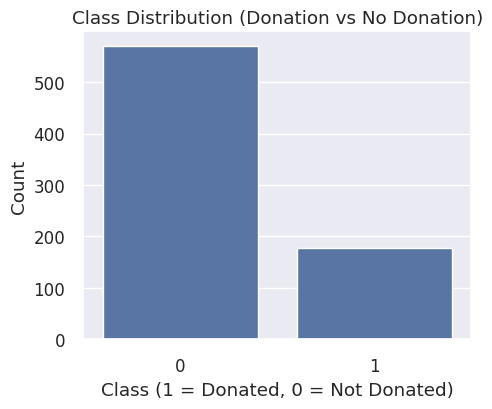

In [14]:
# Bar plot of class distribution
plt.figure(figsize=(5,4))
sns.countplot(x="Class", data=df)
plt.title("Class Distribution (Donation vs No Donation)")
plt.xlabel("Class (1 = Donated, 0 = Not Donated)")
plt.ylabel("Count")
plt.show()

EXPLANATION: The class distribution is clearly imbalanced. A large majority of donors belong to Class 0 (did not donate again), while only a smaller portion are Class 1 (donated again). This imbalance means accuracy alone will not be a reliable evaluation metric, so recall and F1-score for Class 1 will be more important.

## EDA [EXPLORATORY DATA ANALYSIS] AND CORRELATION

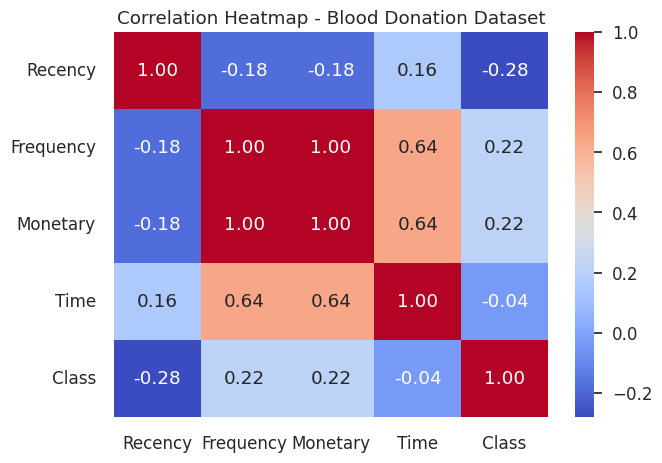

In [15]:
# ============================================================
# 4. CORRELATION & EDA
# ============================================================
corr = df.corr(numeric_only=True)

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap - Blood Donation Dataset")
plt.show()


EXPLANATION:


*  Frequency and Monetary are almost perfectly correlated because
total blood donated increases directly with the number of donations.
*   Recency has a moderate negative correlation with Class, indicating that recent donors are more likely to return.

*   Frequency and Monetary show positive correlations with Class, suggesting that consistent donors are more likely to donate again.
*   Time also correlates with Frequency and Monetary, but its link with Class is weak.

Overall, Recency and Frequency appear to be the strongest behavioural predictors

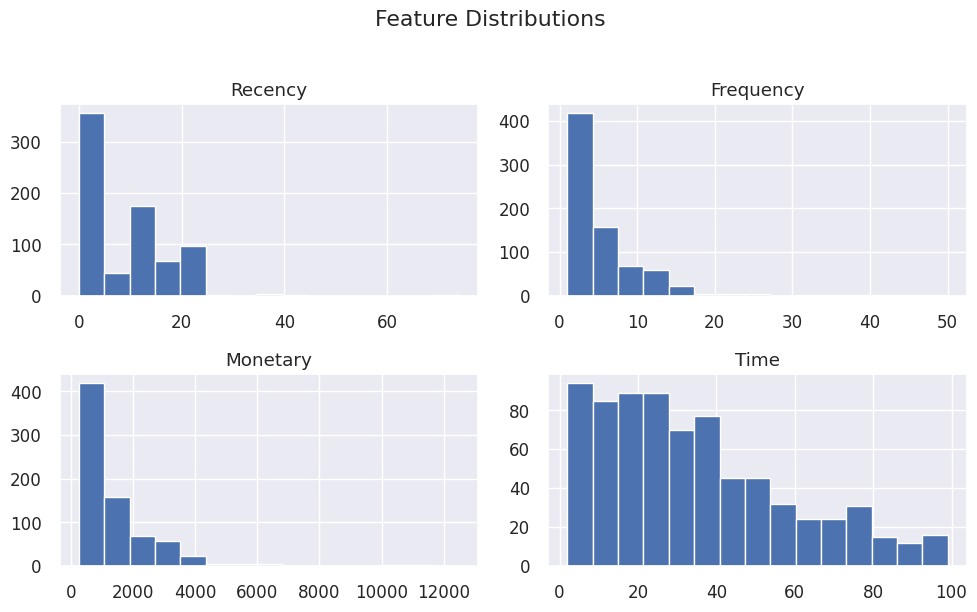

In [16]:
# Histograms of features
feature_cols = ["Recency", "Frequency", "Monetary", "Time"]

df[feature_cols].hist(bins=15, figsize=(10,6))
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


EXPLANATION:

*   Recency is heavily concentrated at low values, meaning many donors donated recently.
*   Frequency shows a strong right skew, with most donors giving only a few times and only a handful being very frequent donors.
*   Monetary mirrors Frequency since the amount donated depends on how many times a donor gave blood.
*   Time spans a wide range, indicating a mix of new donors and long-term donors.

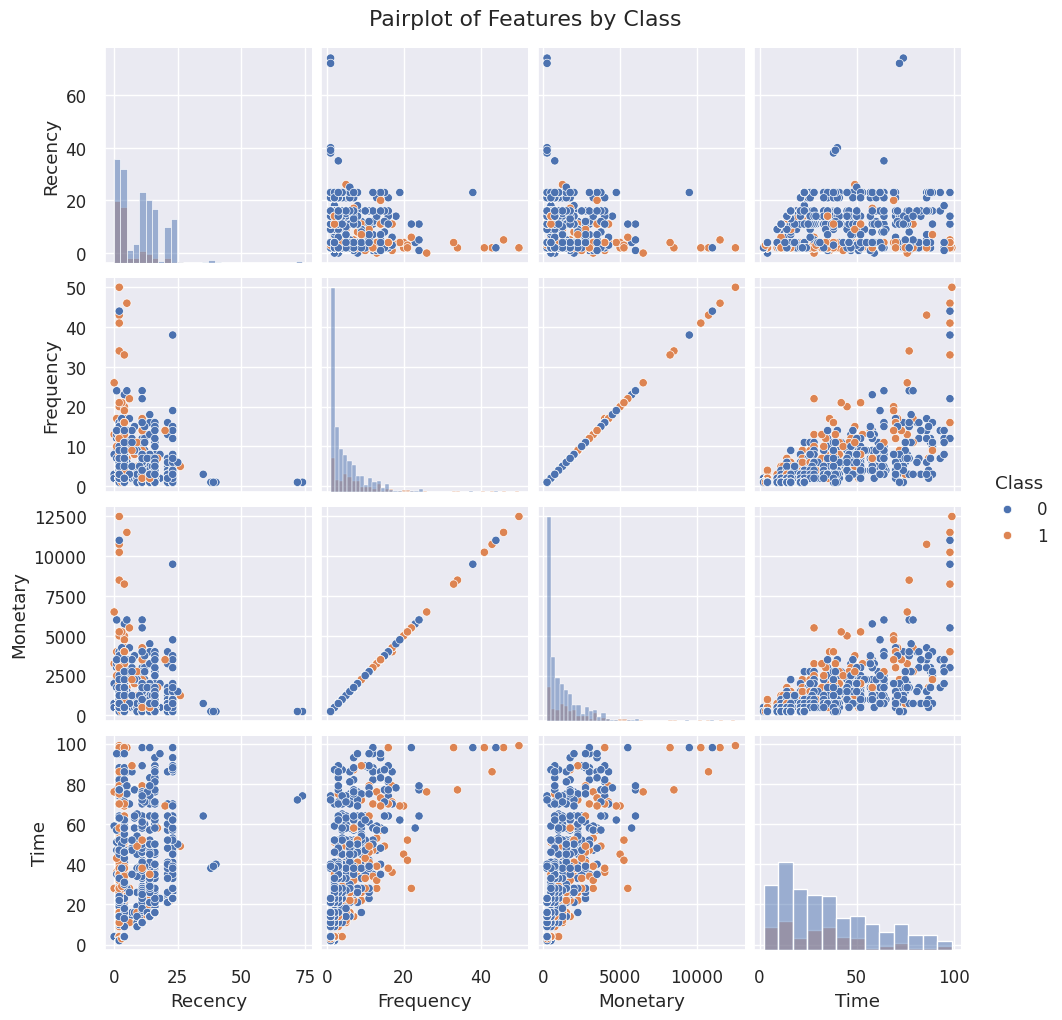

In [17]:
# Pairplot coloured by Class (optional: can be slow)
sns.pairplot(df, vars=feature_cols, hue="Class", diag_kind="hist")
plt.suptitle("Pairplot of Features by Class", y=1.02)
plt.show()

EXPLANATION:
The pairplot shows that Class 1 points (returning donors) tend to cluster at:

*   lower Recency values
*   higher Frequency and Monetary values
This visually confirms behavioural predictors of donor return probability.

In [18]:
# ============================================================
# 5. TRAIN–TEST SPLIT
# ============================================================
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (598, 4)
Test shape: (150, 4)


In [19]:
# ============================================================
# 6.1 MODEL 1 – LOGISTIC REGRESSION
# ============================================================
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

log_reg_pipeline.fit(X_train, y_train)

y_pred_lr = log_reg_pipeline.predict(X_test)
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression – Classification Report")
print(classification_report(y_test, y_pred_lr))

print("Confusion Matrix (Logistic Regression)")
print(confusion_matrix(y_test, y_pred_lr))

metrics_lr = {
    "accuracy": accuracy_score(y_test, y_pred_lr),
    "precision": precision_score(y_test, y_pred_lr),
    "recall": recall_score(y_test, y_pred_lr),
    "f1": f1_score(y_test, y_pred_lr),
    "roc_auc": roc_auc_score(y_test, y_proba_lr),
}
metrics_lr

Logistic Regression – Classification Report
              precision    recall  f1-score   support

           0       0.78      0.97      0.86       114
           1       0.57      0.11      0.19        36

    accuracy                           0.77       150
   macro avg       0.67      0.54      0.52       150
weighted avg       0.73      0.77      0.70       150

Confusion Matrix (Logistic Regression)
[[111   3]
 [ 32   4]]


{'accuracy': 0.7666666666666667,
 'precision': 0.5714285714285714,
 'recall': 0.1111111111111111,
 'f1': 0.18604651162790697,
 'roc_auc': np.float64(0.7872807017543859)}

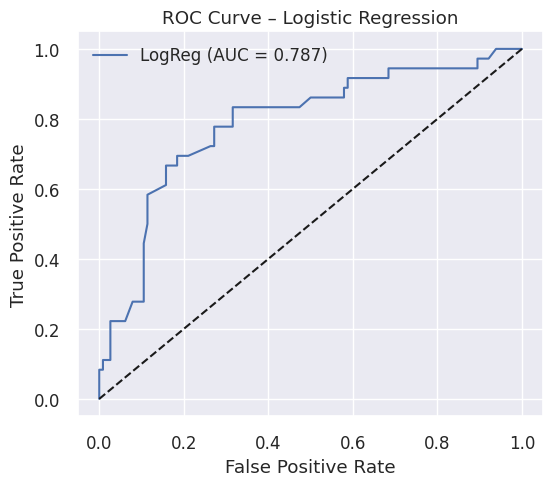

In [20]:
# ROC curve – Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC = {metrics_lr['roc_auc']:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()

In [21]:
# ============================================================
# 6.2. MODEL 2 – RANDOM FOREST
# ============================================================
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Random Forest – Classification Report")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix (Random Forest)")
print(confusion_matrix(y_test, y_pred_rf))

metrics_rf = {
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "precision": precision_score(y_test, y_pred_rf),
    "recall": recall_score(y_test, y_pred_rf),
    "f1": f1_score(y_test, y_pred_rf),
    "roc_auc": roc_auc_score(y_test, y_proba_rf),
}
metrics_rf

Random Forest – Classification Report
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       114
           1       0.41      0.47      0.44        36

    accuracy                           0.71       150
   macro avg       0.62      0.63      0.62       150
weighted avg       0.73      0.71      0.72       150

Confusion Matrix (Random Forest)
[[90 24]
 [19 17]]


{'accuracy': 0.7133333333333334,
 'precision': 0.4146341463414634,
 'recall': 0.4722222222222222,
 'f1': 0.44155844155844154,
 'roc_auc': np.float64(0.7084551656920077)}

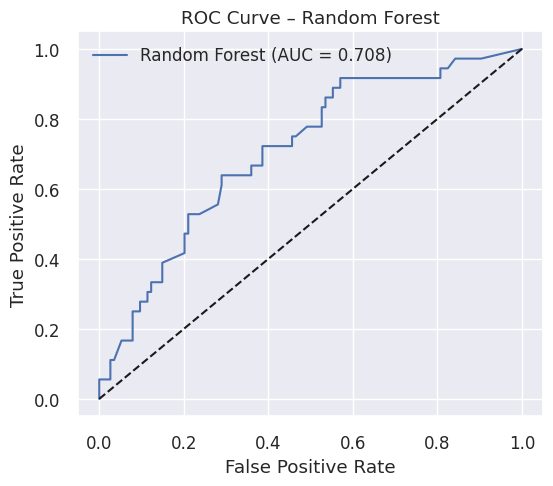

In [22]:
# ROC curve – Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {metrics_rf['roc_auc']:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.show()

In [23]:
# ============================================================
# 6.3. MODEL COMPARISON SUMMARY
# ============================================================
print("Logistic Regression metrics:", metrics_lr)
print("Random Forest metrics      :", metrics_rf)

Logistic Regression metrics: {'accuracy': 0.7666666666666667, 'precision': 0.5714285714285714, 'recall': 0.1111111111111111, 'f1': 0.18604651162790697, 'roc_auc': np.float64(0.7872807017543859)}
Random Forest metrics      : {'accuracy': 0.7133333333333334, 'precision': 0.4146341463414634, 'recall': 0.4722222222222222, 'f1': 0.44155844155844154, 'roc_auc': np.float64(0.7084551656920077)}


In [24]:
# ============================================================
# 7. GRADIENT BOOSTING
# ============================================================
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42)

In [25]:
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Gradient Boosting Classification Report")
print(classification_report(y_test, y_pred_gb))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_gb))

roc_auc_gb = roc_auc_score(y_test, y_proba_gb)
print("ROC-AUC:", roc_auc_gb)

Gradient Boosting Classification Report
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       114
           1       0.64      0.39      0.48        36

    accuracy                           0.80       150
   macro avg       0.73      0.66      0.68       150
weighted avg       0.78      0.80      0.78       150

Confusion Matrix
[[106   8]
 [ 22  14]]
ROC-AUC: 0.7337962962962964


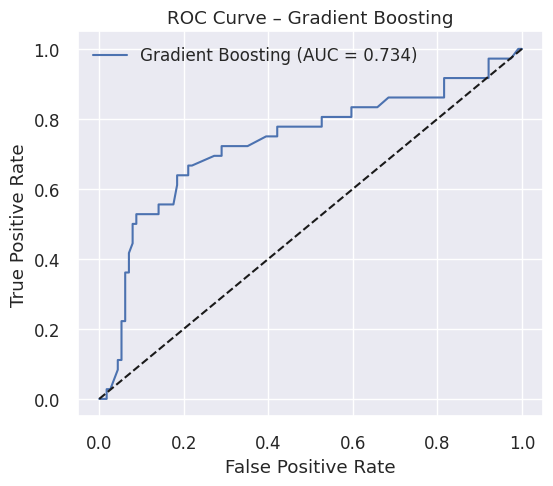

In [27]:
from sklearn.metrics import roc_curve

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)

plt.figure(figsize=(6,5))
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {roc_auc_gb:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Gradient Boosting")
plt.legend()
plt.show()

In [28]:
# ============================================================
# 8. FEATURE IMPORTANCE (from Random Forest)
# ============================================================
rf_model = rf_pipeline.named_steps["clf"]
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance

,feature,importance
3,Time,0.415251
0,Recency,0.298934
1,Frequency,0.144313
2,Monetary,0.141502


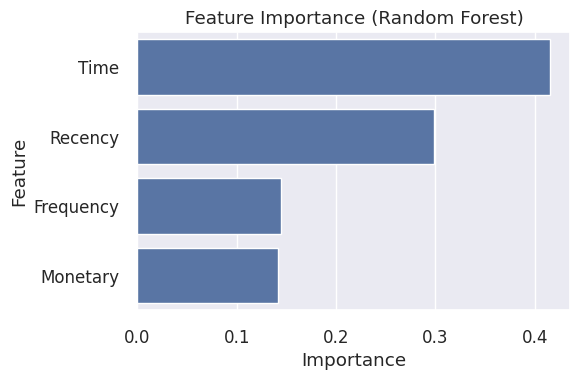

In [29]:
plt.figure(figsize=(6,4))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [30]:
# ============================================================
# 9. PERSONALISED RECOMMENDATION FUNCTION
# ============================================================
# We'll use the better model for recall/F1 – typically Random Forest here.
best_model = rf_pipeline

def generate_recommendation(recency, frequency, monetary, time):
    """
    Input: values for a single individual
    Output: model prediction + human-readable recommendation
    """
    input_df = pd.DataFrame({
        "Recency": [recency],
        "Frequency": [frequency],
        "Monetary": [monetary],
        "Time": [time]
    })

    proba = best_model.predict_proba(input_df)[0, 1]
    pred = 1 if proba >= 0.5 else 0

    if pred == 1:
        recommendation = (
            "The model predicts a HIGH probability that this person will donate "
            "blood again. Encourage regular donation and provide reminders."
        )
    else:
        recommendation = (
            "The model predicts a LOW probability of future donation. "
            "Consider targeted engagement, health education, or personalised "
            "follow-up to motivate donation."
        )

    return {
        "predicted_class": int(pred),
        "probability_of_donation": float(proba),
        "recommendation": recommendation
    }

# Example usage
example = generate_recommendation(recency=2, frequency=20, monetary=5000, time=45)
example

{'predicted_class': 1,
 'probability_of_donation': 0.9694135684074543,
 'recommendation': 'The model predicts a HIGH probability that this person will donate blood again. Encourage regular donation and provide reminders.'}

In [31]:
# ============================================================
# 10. OPTIONAL: CROSS-VALIDATION (for report)
# ============================================================
cv_scores_rf = cross_val_score(
    rf_pipeline, X, y,
    cv=5,
    scoring="f1"
)
print("Random Forest 5-fold F1 scores:", cv_scores_rf)
print("Mean F1:", cv_scores_rf.mean())

Random Forest 5-fold F1 scores: [0.35135135 0.275      0.         0.38709677 0.17777778]
Mean F1: 0.2382451806645355
